# MachIne Learning Code for HArvesting Exoplanet Lightcurves

Input data include:
- "Local" view light curve time profile (61 time bins), all 3 aperture depth channels: $X_{\rm local}$, with dimension $n\times 3\times 61$
- "Global" view light curve time profile: $X_{\rm global}$, with dimension $n\times 3 \times 201$
- Depths from local and global light curves, all apertures: $X_{\rm depths}$, with dimension $n\times 6$

Labels y has dimension $n$, each label is either 0 (non-planet) or 1 (planet)

In [1]:
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt
import pickle

import torch
from torch import nn
from torch.nn import (Linear, ReLU, Conv1d, Flatten, Conv2d, Sequential,MaxPool1d, MaxPool2d, Dropout, CrossEntropyLoss)
from torch.optim import Adam

import sklearn

Define a function to read some pickled data into numpy array.

0 0


([<matplotlib.lines.Line2D at 0x1a2cba8c10>], -0.028368297702041488)

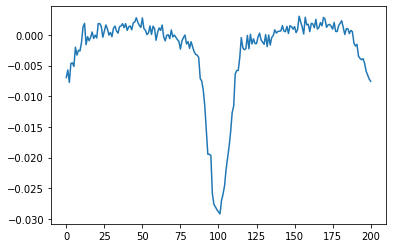

In [2]:
pickle_dir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/"
testf = open(pickle_dir + "sector-13.pickle",'rb')
test = pickle.load(testf)
test[0].keys()
depths = np.array([test[i]['GlobalDepths'][1] for i in range(len(test))])
print(np.sum(np.isnan(depths) == 1),np.sum(depths == 0))
# plt.hist([test[i]['LocalDepths'][1] for i in range(len(test))])
labelss = np.array([test[i]['label'] for i in range(len(test))])
# np.sum(labelss)
plt.plot(test[10]['GlobalView'][0]), test[10]['GlobalDepths'][0]

In [3]:
def read_pickle(filepath):
    
    assert os.path.exists(filepath)
    ft = open(filepath,'rb')
    f = pickle.load(ft)    
    
    nfiles = len(f)
    
    # Views
    localviews = np.zeros((nfiles,3,61))
    globalviews = np.zeros((nfiles,3,201))
    
    # Scalar features
    std_depths = np.zeros((nfiles,2))
    true_depths = np.zeros((nfiles,6))
    astronet_score = np.zeros((nfiles,1))
    stellar_radii = np.zeros((nfiles,1))

    # Labels
    labels = np.zeros((nfiles,))

    
    for i,file in enumerate(f):
        
        stdcut = (np.std(file['LocalDepths']) < 1) and (np.std(file['GlobalDepths']) < 1)
        non_zero_depths = ((np.sum(file['LocalDepths'] == 0) + np.sum(file['GlobalDepths'] == 0)) == 0)
        no_nans = np.sum(np.isnan(file['LocalView'])) + np.sum(np.isnan(file['GlobalView'])) == 0
        
        if no_nans and non_zero_depths and stdcut:
        
            localviews[i] = file['LocalView']
            globalviews[i] = file['GlobalView']
            labels[i] = file['label']

            astronet_score[i] = np.array([file['AstroNetScore']])
            std_depths[i] = np.array([np.std(file['LocalDepths']),np.std(file['GlobalDepths'])])
            true_depths[i] = np.hstack([file['LocalDepths'],file['GlobalDepths']])    
            stellar_radii[i] = np.array([file['StellarParams']['rad']])
    ft.close()
    return localviews, globalviews, std_depths, true_depths, astronet_score, stellar_radii, labels

Load data $X_{\rm local},X_{\rm global},X_{\rm depths},y$, which contain combined data across multiple sectors. 

In [4]:
verbose = 1
pickle_dir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/"

std_depths = np.zeros((0,2))
true_depths = np.zeros((0,6))
astronets = np.zeros((0,1))
stellar_radii = np.zeros((0,1))

all_localviews = np.zeros((0,3,61))
all_globalviews = np.zeros((0,3,201))
all_labels = np.zeros((0,),dtype=int)

# append with data from each sector
for sector in range(1,22):
    
    filepath = pickle_dir + 'sector-{}.pickle'.format(sector)
    print(filepath)
    localviews, globalviews, std_depth, true_depth, astronet_score, stellar_rad, labels = read_pickle(filepath)
    
    std_depths = np.append(std_depths, std_depth,axis=0)
    true_depths = np.append(true_depths,true_depth,axis=0)
    astronets = np.append(astronets, astronet_score, axis = 0)
    stellar_radii = np.append(stellar_radii, stellar_rad , axis = 0)
    
    
    all_localviews = np.append(all_localviews, localviews,axis=0)
    all_globalviews = np.append(all_globalviews, globalviews,axis=0)
    all_labels = np.append(all_labels,labels)

if verbose:
    print("X_global.shape = ", all_globalviews.shape)
    print("X_local.shape  = ", all_localviews.shape)
    print("X_depths.shape = ", true_depths.shape)
    print("y.shape        = ", all_labels.shape)

/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-1.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-2.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-3.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-4.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-5.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-6.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-7.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-8.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-9.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-10.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-11.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-12.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-13.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-14.pickle
/Users/hblim/Dr

Visualize the depths data

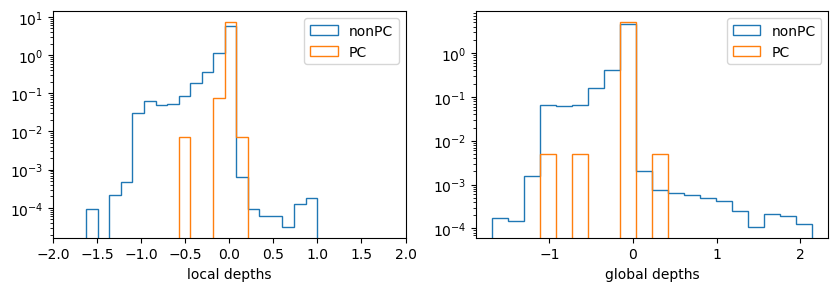

In [5]:
PCs = (all_labels == 1)
nonPCs = (all_labels == 0)
localstds = true_depths[:,1] 
globalstds = true_depths[:,5] 

fig, (ax1,ax2) = plt.subplots(ncols = 2,figsize = (10,3),dpi=100)
plt.sca(ax1)
n, bins, p = plt.hist(localstds[nonPCs],20,density=True,label='nonPC',histtype='step');
plt.hist(localstds[PCs],bins,density=True,label='PC',histtype='step');
plt.yscale('log')
plt.xlim([-2,2])
plt.xlabel('local depths')
plt.legend()

plt.sca(ax2)
n, bins, p = plt.hist(globalstds[nonPCs],20,density=True,label='nonPC',histtype='step');
plt.hist(globalstds[PCs],bins,density=True,label='PC',histtype='step');
plt.yscale('log')
# plt.xlim([-4,10])
plt.xlabel('global depths')
plt.legend();

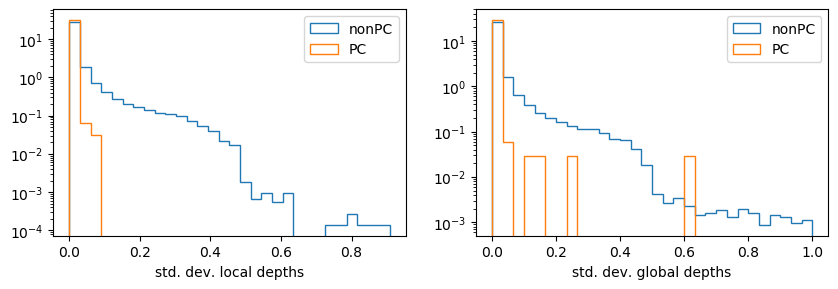

In [6]:
PCs = (all_labels == 1)
nonPCs = (all_labels == 0)
localstds = std_depths[:,0] 
globalstds = std_depths[:,1] 

fig, (ax1,ax2) = plt.subplots(ncols = 2,figsize = (10,3),dpi=100)
plt.sca(ax1)
n, bins, p = plt.hist(localstds[nonPCs],30,density=True,label='nonPC',histtype='step');
plt.hist(localstds[PCs],bins,density=True,label='PC',histtype='step');
plt.yscale('log')

plt.xlabel('std. dev. local depths')
plt.legend()

plt.sca(ax2)
n, bins, p = plt.hist(globalstds[nonPCs],30,density=True,label='nonPC',histtype='step');
plt.hist(globalstds[PCs],bins,density=True,label='PC',histtype='step');

plt.yscale('log')

plt.xlabel('std. dev. global depths')
plt.legend();

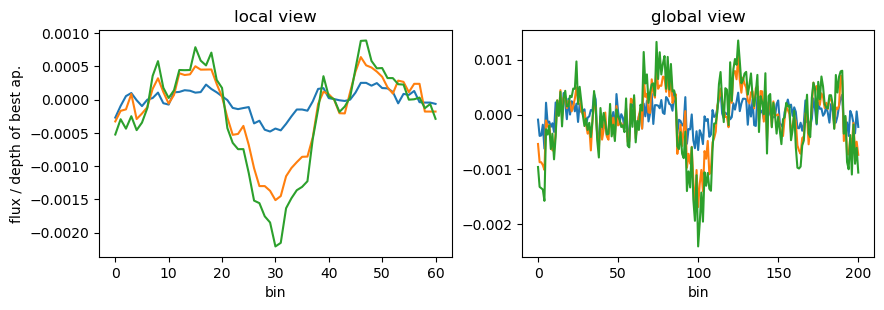

In [7]:
# choose sample index
i = np.arange(len(all_labels))[nonPCs][1000]
all_labels[i]

fig, (ax1,ax2) = plt.subplots(ncols = 2,figsize = (10,3),dpi=100)
plt.sca(ax1)
[plt.plot(all_localviews[i][j]) for j in range(3)], all_labels[i]
# plt.axhline(y = 1,color="C1")
plt.xlabel('bin')
plt.ylabel('flux / depth of best ap.')
plt.title('local view')

plt.sca(ax2)
[plt.plot(all_globalviews[i][j]) for j in range(3)], all_labels[i]
# plt.axhline(y = 1,color="C1")
plt.xlabel('bin')
plt.title('global view');

Function to break data into training and testing data

In [8]:
from sklearn.model_selection import StratifiedKFold

def split_data(X,y,n_fold):

    skf = StratifiedKFold(n_splits=5,shuffle=True)

    # currently only using the first fold
    train_i, test_i = next(skf.split(X, y))
    
    Xtrain, ytrain = (X[train_i,:],y[train_i])
    Xtest, ytest = (X[test_i,:],y[test_i])

    return (Xtrain, ytrain), (Xtest, ytest)

To design architecture, helper script to calculate output dimensions given input dimension

In [9]:
padding=0
dilation=1
kernel_size=5
stride=3

Lin = 41
Lout = np.floor((1/stride) * (Lin + 2 * padding - dilation * (kernel_size-1) - 1) + 1)
Lout

13.0

Define Model architecture

In [10]:
class TriInput_Module(nn.Module):
    
    def __init__(self):
        super(TriInput_Module, self).__init__()

        # self.weights = torch.parameters([1,1,1])
        
        # [1] local view input
        self.Local_ModuleList = nn.ModuleList([
            
            # (C_in, L_in) = (3, 61), 
            nn.Conv1d(in_channels=3, out_channels=8, kernel_size=5),nn.ReLU(),
            # (C_in, L_in) = (16, 57)
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5),nn.ReLU(),
            # (C_in, L_in) = (16, 53), (C_out, L_out) = (16, 24)
            nn.MaxPool1d(kernel_size=7,stride=2)
            
#             # (C_in, L_in) = (16, 24), 
#             nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),
#             # (C_in, L_in) = (32, 20), 
#             nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5),
#             # (C_in, L_in) = (32,16), (C_out, L_out) = (32, 5)
#             nn.MaxPool1d(kernel_size=7,stride=2)
        ])
        
        # [2] global view input
        self.Global_ModuleList = nn.ModuleList([

            # (C_in, L_in) = (3, 201), 
            nn.Conv1d(in_channels=3, out_channels=8, kernel_size=5),nn.ReLU(),
            # (C_in, L_in) = (16, 197)
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5),nn.ReLU(),
            # (C_in, L_in) = (16, 193), 
            nn.MaxPool1d(kernel_size=5,stride=2),

#             # (C_out, L_out) = (16, 95), 
#             nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),
#             # (C_out, L_out) = (32, 91), 
#             nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5),
#             # (C_out, L_out) = (32, 87), (32, 42), 
#             nn.MaxPool1d(kernel_size=5,stride=2),
            
#             # (C_out, L_out) = (32, 42), 
#             nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5),
#             # (C_out, L_out) = (64, 38), 
#             nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
#             # (C_out, L_out) = (64, 34), (64, 15), 
#             nn.MaxPool1d(kernel_size=5,stride=2),  
        ])
        
        # [1] + [2] + [3] combined layers
        self.Combined_ModuleList = nn.ModuleList([
            nn.Linear(in_features = (8 * 95 + 8 * 24 + 2), out_features=512),
            nn.Linear(in_features = 512, out_features=512),
            nn.Linear(in_features = 512, out_features=2)])
        
    def forward(self, X):
        X = X.float()
        (N, D) = X.size()
        (Dlocal,Dglobal) = (3 * 61, 3 * 201)
        
        # Exract X -> (Xlocal,Xglobal,Xdepths)
        Xlocal = X[:,0:Dlocal].view(N,3,61)
        Xglobal = X[:,Dlocal:Dlocal+Dglobal].view(N,3,201)
        Xdepths = X[:,Dlocal+Dglobal:].view(N,2)
        
        # Process Xlocal
        for l in self.Local_ModuleList:
            Xlocal = l(Xlocal.float())

        # Process Xglobal
        for l in self.Global_ModuleList:
            Xglobal = l(Xglobal.float())
        
        # weight Xlocal, Xglobal, Xdepths; apply softmax
        
        # Combine with depths 
        X = torch.cat((Xlocal.view(N, 8 * 24 ), 
                       Xglobal.view(N,8 * 95),
                       Xdepths), 1)
        
        # Process X
        for l in self.Combined_ModuleList:
            X = l(X.float())

        return X.float()

In [11]:
class BiInput_Module(nn.Module):
    
    def __init__(self):
        super(BiInput_Module, self).__init__()
        
#         self.Global_ModuleList = nn.ModuleList([

#             # (C_in, L_in) = (3, 201), 
#             nn.Conv1d(in_channels=3, out_channels=8, kernel_size=5),nn.ReLU(),
#             # (C_in, L_in) = (8, 197), 
#             nn.MaxPool1d(kernel_size=5,stride=2),

#             # (C_in, L_in) = (8, 97), 
#             nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5),nn.ReLU(),
#             # (C_in, L_in) = (16, 93), 
#             nn.MaxPool1d(kernel_size=5,stride=2),
            
#             # (C_out, L_out) = (16, 45), 
#             nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),nn.ReLU(),
#             # (C_out, L_out) = (32, 41), (C_out, L_out) = (32, 13), 
#             nn.MaxPool1d(kernel_size=5,stride=3),
#         ])
        
        self.Global_LinearModuleList = nn.ModuleList([
            nn.Linear(in_features = 201 * 3, out_features=500),
            nn.Linear(in_features = 500, out_features=500),
            nn.Linear(in_features = 500, out_features=100)])
        
        # [1] + [2] + [3] combined layers
        self.Combined_ModuleList = nn.ModuleList([
            nn.Linear(in_features = 2 + 100, out_features=512),nn.ReLU(),
            nn.Linear(in_features = 512, out_features=512),nn.ReLU(),
            nn.Linear(in_features = 512, out_features=2)])
        
        
    def forward(self, X):
        X = X.float()
        (N, D) = X.size()
        Dglobal = (3 * 201)
        
        # Exract X -> (Xlocal,Xglobal,Xdepths)
#         Xglobal  = X[:,:Dglobal]
        Xglobal  = X[:,:Dglobal].view(N,3*201)
        Xdepths = X[:,Dglobal:].view(N,2)
        
        # Process Xlocal
        for l in self.Global_LinearModuleList:
            Xglobal = l(Xglobal.float())
            
        # Combine with depths 
        X = torch.cat((Xglobal.view(N, 10),
                       Xdepths), 1)
        
        # Process X
        for l in self.Combined_ModuleList:
            X = l(X.float())

        return X.float()

In [12]:
class MonoInput_Module(nn.Module):
    
    def __init__(self):
        super(MonoInput_Module, self).__init__()

        nhl = 5
        self.Combined_ModuleList = nn.ModuleList([
            nn.Linear(in_features = 3, out_features=nhl),nn.ReLU(),
            nn.Linear(in_features = nhl, out_features=nhl),nn.ReLU(),
            nn.Linear(in_features = nhl, out_features=2)])
        
    def forward(self, X):
        
        # Process X
        for l in self.Combined_ModuleList:
            X = l(X.float())

        return X.float()

Implement training of model

In [35]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

def make_deterministic():
    torch.manual_seed(10)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(10)

def weight_reset(l):
    if isinstance(l, Conv2d) or isinstance(l, Linear):
        l.reset_parameters()

def make_iter(X, y, weights, batch_size=1):
    X, y = torch.from_numpy(X), torch.from_numpy(y)
    sampler = WeightedRandomSampler(weights[y], batch_size, replacement=True)
    return DataLoader(TensorDataset(X, y), batch_size=batch_size,sampler=sampler)

def run_pytorch(train, test, epochs, model_type='MonoInput', lr = 1e-2, wr = 50, verbose=True):
    
    make_deterministic()
    (X_train, y1), (X_val, y2) = train, test

    # Imbalanced Classes Weights
    weights = torch.FloatTensor(compute_class_weight('balanced',[0,1],y1))
    weights2 = torch.FloatTensor(np.array([1,wr]))

    # Make Dataset Iterables
    train_iter = make_iter(X_train, y1, weights, batch_size=32)
    val_iter = make_iter(X_val, y2, weights, batch_size=32)

    # Model specification
    if model_type == 'MonoInput': model = MonoInput_Module()
    elif model_type == 'BiInput': model = BiInput_Module()
    elif model_type == 'TriInput': model = TriInput_Module()
        
    # Define the optimization
    optimizer = Adam(model.parameters(),lr = lr)
    criterion = CrossEntropyLoss(weight=weights2)
   
    # Fit the model
    history = {'epoch_loss': [],
               'epoch_val_loss': [],
               'epoch_acc': [],
               'epoch_val_acc': []}
    
    train_m, vali_m = model_fit(model, train_iter, epochs=epochs, 
                                optimizer=optimizer, criterion=criterion,
                                validation_iter=val_iter,
                                verbose=verbose,history=history)
 
    (train_loss, train_acc) = train_m
    (vali_loss, val_acc) = vali_m
    
    predict = nn.functional.softmax(model(torch.FloatTensor(X_val)),dim=1).data.numpy()
    return sklearn.metrics.precision_recall_curve(y2, np.amax(predict,axis=1) , pos_label=1), history

Fit the model, and udpate parameters

In [36]:
def model_fit(model, train_iter, epochs, optimizer, criterion,
              validation_iter, history, verbose, model_reg=None):

    av_train_loss, av_train_acc, av_vali_loss, av_vali_acc = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc_score = call_model('train', model, train_iter, optimizer, criterion, model_reg=model_reg)
        vali_loss, vali_acc_score  = call_model('vali', model, validation_iter, optimizer, criterion)
        if verbose: print("epoch: {} | TRAIN: loss {} acc {} | VALI: loss {} acc {}".format(epoch,
                                                                 round(train_loss, 5), 
                                                                 round(train_acc_score, 5), 
                                                                 round(vali_loss, 5), 
                                                                 round(vali_acc_score, 5)))
        if history is not None:
            history['epoch_loss'].append(train_loss)
            history['epoch_val_loss'].append(vali_loss)
            history['epoch_acc'].append(train_acc_score)
            history['epoch_val_acc'].append(vali_acc_score)

        av_train_loss.append(train_loss)
        av_train_acc.append(train_acc_score)
        av_vali_loss.append(vali_loss)
        av_vali_acc.append(vali_acc_score)
    
    return ((np.mean(av_train_loss), np.mean(av_train_acc)), (np.mean(av_vali_loss), np.mean(av_vali_acc)))

def call_model(mode, model, data_iter, optimizer, criterion, model_reg=None):
    epoch_loss = []
    hits = []
    items = []
    
    # This is to manually regularize model, should return a value that is 
    # a function of the model parameters.
    if model_reg == None:
        model_reg = lambda x: 0

    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X.float())

            batch_loss = criterion(y_hat.float(), y.long()) 

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            predpropbs = nn.functional.softmax(y_hat,dim=1)
            predall = y_hat.argmax(1)
            epoch_loss.append(batch_loss.item())
            hits.append((y_hat.argmax(1) == y.long()).sum())
            items.append(X.shape[0])

#             print(X[y==1,0])
#             print(np.hstack([predpropbs.data.numpy(),predall.long().reshape(X.shape[0],1),y.long().data.numpy().reshape(X.shape[0],1)]))
    
        loss = np.sum(epoch_loss) / np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

Combine data into single flattened input array 
$X = \lbrace X_{\rm local},X_{\rm global},X_{\rm depths} \rbrace$

Also convert class labels {0 and 1} to {-1 and 1}

In [34]:
verbose = 1
ntotal = len(all_labels)
X = np.zeros((ntotal,0))
# X = np.append(X, all_localviews.reshape((ntotal,3*61)),axis=1)
# X = np.append(X, all_globalviews.reshape((ntotal,3*201)),axis=1)
X = np.append(X, std_depths.reshape((ntotal,2)),axis=1)
X = np.append(X, astronets.reshape((ntotal,1)),axis=1)
# X = np.append(X, true_depths.reshape((ntotal,6)),axis=1)
X = np.append(X, all_labels.reshape((ntotal,1)),axis=1)

# downsample majority class
PCs = all_labels == 1
nonPCs = all_labels == 0

X_PC = X[PCs]
X_nPC = X[nonPCs]

Xfil = np.vstack([X_PC,X_nPC])
np.random.shuffle(Xfil)

X = Xfil[:,:-1]
y = Xfil[:,-1].astype(int)
np.sum(y==1),np.sum(y==0)

(1038, 247354)

Evaluate model with area under precision-recall curve

In [115]:
from scipy.integrate import simps

def AUC(precision_recall):

    xdata = precision_recall[1][-2:0:-1]
    ydata =  precision_recall[0][-2:0:-1]

    dx = 0.001
    xint = np.arange(xdata[0],xdata[-1],dx)
    yint = np.interp(xint,xdata,ydata)

    return simps(yint,dx=dx)

Execute on data for a single learning rate, weight ratio, epochs

In [29]:
import time

ep = 900
lr = 1e-2
wr = 50

train, test = split_data(X,y,5)

t0 = time.time()
pr_curve, hist = run_pytorch(train,test,ep,model_type = 'MonoInput',lr=lr,wr=wr,verbose=0);
tf = time.time() - t0

print("Run time: {:.2f} seconds".format(tf))
print("(area, lr, wr, epochs) = ({:.1e}, {:.1e}, {:.2f}, {:d})".format( \
                                                AUC(pr_curve), lr, wr, ep))

Run time: 1.80 seconds


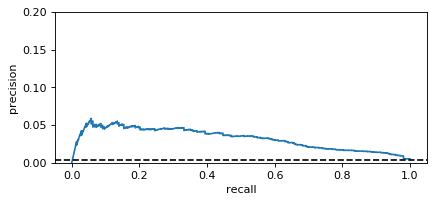

In [31]:
plt.figure(figsize=(6,2.5),dpi=80)

plt.plot(pr_curve[1][:-1],pr_curve[0][:-1])
plt.axhline(y = np.sum(y == 1) / len(y),color='k',linestyle='--')
plt.ylabel('precision')
plt.xlabel('recall')
plt.ylim([0,.2]);

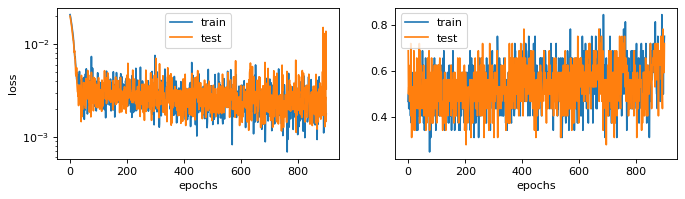

In [33]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,2.5), dpi = 80, ncols=2)

plt.sca(ax1)
plt.plot(hist['epoch_loss'], label='train')
plt.plot(hist['epoch_val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')

plt.sca(ax2)
plt.plot(hist['epoch_acc'],label='train')
plt.plot(hist['epoch_val_acc'] ,label='test')
plt.legend()
plt.xlabel('epochs');

Execute data and optimize over the hyperparameters: learning rate, weight ratio, and epoch histories

Evaluate each outcome with the area under the curve

In [162]:
# hyper parameter ranges to test
lrs = [3.2e-2]
eps = [280,290,300]
wrs = np.arange(20,35,5)

prs = []
areas = []
hists = []

for i, lr in enumerate(lrs):

    temp1_prs = []
    temp1_hists = []
    temp1_areas = []
    
    for j, ep in enumerate(eps):

        temp2_prs = []
        temp2_areas = []
        temp2_hists = []

        for k, wr in enumerate(wrs):
            
            print("Progress ({:2d}/{:2d}) ({:2d}/{:2d}) ({:2d}/{:2d}) \r".format( \
                i+1, len(lrs), j+1, len(eps), k+1, len(wrs)),end="")
            
            prec_rec, hist = run_pytorch(train, test, ep, model_type = 'MonoInput',
                                         lr=lr, wr=wr,verbose=0);
            temp2_prs.append([prec_rec[1],prec_rec[0]])
            temp2_areas.append(AUC(prec_rec))
            temp2_hists.append(hist)
            
        temp1_areas.append(temp2_areas)
        temp1_prs.append(temp2_prs)
        temp1_hists.append(temp2_hists)
    
    areas.append(temp1_areas)
    prs.append(temp1_prs)
    hists.append(temp1_hists)

Best i,j,k ( 1/ 1) ( 3/ 3) ( 3/ 3)
Best outcome: (area, lr, wr, epochs) = (5.5e-02, 3.2e-02, 30.00, 300)


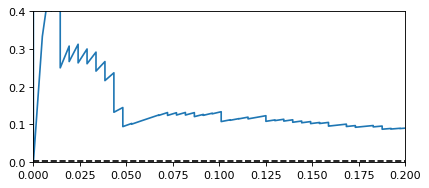

In [163]:
areas = np.array(areas)

(i,j,k) = np.unravel_index(areas.argmax(), areas.shape)
print("Best i,j,k ({:2d}/{:2d}) ({:2d}/{:2d}) ({:2d}/{:2d})".format( \
                i+1, len(lrs), j+1, len(eps), k+1, len(wrs)))

plt.figure(figsize=(6,2.5),dpi=80)

plt.plot(prs[i][j][k][0],prs[i][j][k][1])

plt.axhline(y = np.sum(y == 1) / len(y),color='k',linestyle='--')

plt.xlim([0,.2])
plt.ylim([0,.4])
print("Best outcome: (area, lr, wr, epochs) = ({:.1e}, {:.1e}, {:.2f}, {:d})".format(areas[i][j][k], lrs[i], wrs[k], eps[j]))

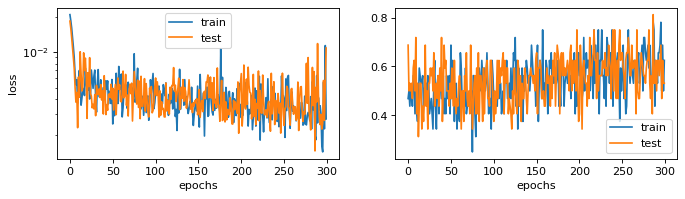

In [164]:
history_epochs = hists[i][j][k]

fig, (ax1, ax2) = plt.subplots(figsize = (10,2.5), dpi = 80, ncols=2)

plt.sca(ax1)
plt.plot(history_epochs['epoch_loss'], label='train')
plt.plot(history_epochs['epoch_val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')

plt.sca(ax2)
plt.plot(history_epochs['epoch_acc'],label='train')
plt.plot(history_epochs['epoch_val_acc'] ,label='test')
plt.legend()
plt.xlabel('epochs');